In [22]:
import numpy as np 
import pandas as pd 
from glob import glob

In [35]:
slide_outs = '/ix/djishnu/Jane/SLIDESWING_ihome/alok_data/out_files/0.1_0.5_out'
z_matrix = pd.read_csv(f'{slide_outs}/z_matrix.csv', index_col=0)

sig_LFs = glob(slide_outs+'/*gene_list*')
sig_LFs = [f"Z{path.replace('.txt','').rsplit('Z', 1)[1]}" for path in sig_LFs]

sig_LFs

['Z118', 'Z107']

In [37]:
z_matrix = z_matrix[sig_LFs].values
z_matrix.shape

(73, 2)

In [3]:
n, k = z_matrix.shape   # n samples, k LFs
l = 20                  # plm embedding dimension

y = np.random.randint(0, 2, n)

In [4]:
plm_embedding = np.random.rand(n, l)
plm_embedding.shape

(73, 20)

In [5]:
# fit z-matrix in linear part to get beta and LP

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(z_matrix, y)

LP = reg.predict(z_matrix)

beta = reg.coef_        # these should already be calculated in SLIDE, would be good to check if they match
beta.shape

(7,)

In [6]:
# fit with interaction terms to get NP

interaction_terms = np.einsum('ij,ik->ijk', z_matrix, plm_embedding)
interaction_terms.shape

(73, 7, 20)

In [7]:
interaction_terms = interaction_terms.reshape(n, k*l)   
interaction_terms.shape

(73, 140)

In [8]:
# identify significant interactions with knockoffs

from knockpy import KnockoffFilter

kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso')
rejections = kfilter.forward(X=interaction_terms, y=y, fdr=0.1, shrinkage="ledoitwolf")

/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/knockpy/mrc.py:276: UserWarning: 
	---------------------------------------------------------
	---------------------------------------------------------
	The choldate package is not installed:
	solving for MVR or maxent knockoffs without it will be 
	~5x slower. For instructions on how to install choldate,
	see https://amspector100.github.io/knockpy/installation.html.
	To disable this warning, set choldate_warning=False as an 
	argument or a knockoff_kwarg.
	----------------------------------------------------------
	----------------------------------------------------------

  warnings.warn(constants.CHOLDATE_WARNING)


In [9]:
# filter out non-significant interactions

interaction_terms = interaction_terms * rejections 
len(np.where(interaction_terms == 0)[0])

10220

In [10]:
# subtract LP from y
y = y - LP

# fit interaction terms to y
reg = LinearRegression().fit(interaction_terms, y)

beta_interaction = reg.coef_
beta_interaction.shape

(140,)

In [11]:
interaction_terms = interaction_terms.reshape(n, k, l)
beta_interaction = beta_interaction.reshape(k,l)

interaction_terms.shape, beta_interaction.shape

((73, 7, 20), (7, 20))

In [12]:
NP = np.einsum('ijk,jk->ij', interaction_terms, beta_interaction)
NP.shape

(73, 7)

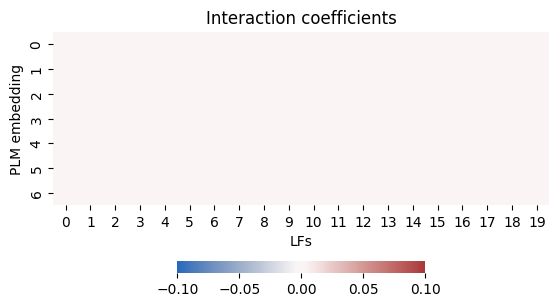

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

max = np.max(np.abs(beta_interaction))

fig, ax = plt.subplots()
sns.heatmap(beta_interaction, square=True, ax=ax, vmin=-max, vmax=max, 
            cmap='vlag', cbar_kws={'orientation': 'horizontal', 'shrink': 0.5})
_ = ax.set(xlabel='LFs', ylabel='PLM embedding', title='Interaction coefficients')